# Titanic Survival

In [233]:
import math

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler

In [234]:
def read_data(path: str):
    data = pd.read_csv(path)
    data.rename(
        {
            "PassengerId": "passenger_id",
            "Survived": "survived",
            "Pclass": "socioeconomic_status",
            "Name": "name",
            "Sex": "sex",
            "Age": "age",
            "SibSp": "n_siblings_and_spouses",
            "Parch": "n_parents_and_children",
            "Ticket": "ticket_number",
            "Fare": "fare",
            "Cabin": "cabin",
            "Embarked": "embarkation_port",
        },
        axis=1,
        inplace=True,
    )
    data.drop(["passenger_id"], axis=1, inplace=True)
    return data


data = read_data("./data/train.csv")

In [235]:
def enrich_data(data: pd.DataFrame):
    data["title"] = (
        data["name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    )
    data["cabin_block"] = data["cabin"].str.slice(0, 1)
    data["cabin_number"] = data["cabin"].str.slice(1)
    data = data.drop(["name", "ticket_number", "cabin"], axis=1)
    return data


data = enrich_data(data)

In [236]:
print("--------------------------------------------------")
print("Sample")
print("--------------------------------------------------")

data.sample(10)

--------------------------------------------------
Sample
--------------------------------------------------


,survived,socioeconomic_status,sex,age,n_siblings_and_spouses,n_parents_and_children,fare,embarkation_port,title,cabin_block,cabin_number
516,1,2,female,34.0,0,0,10.5000,S,Mrs,F,33
203,0,3,male,45.5,0,0,7.2250,C,Mr,NaN,NaN
278,0,3,male,7.0,4,1,29.1250,Q,Master,NaN,NaN
474,0,3,female,22.0,0,0,9.8375,S,Miss,NaN,NaN
159,0,3,male,NaN,8,2,69.5500,S,Master,NaN,NaN
447,1,1,male,34.0,0,0,26.5500,S,Mr,NaN,NaN
181,0,2,male,NaN,0,0,15.0500,C,Mr,NaN,NaN
440,1,2,female,45.0,1,1,26.2500,S,Mrs,NaN,NaN
321,0,3,male,27.0,0,0,7.8958,S,Mr,NaN,NaN
700,1,1,female,18.0,1,0,227.5250,C,Mrs,C,62 C64


In [237]:
print("--------------------------------------------------")
print("Data Types")
print("--------------------------------------------------")

for column in data.columns:
    print(f"{column}: {data[column].dtypes}")

--------------------------------------------------
Data Types
--------------------------------------------------
survived: int64
socioeconomic_status: int64
sex: object
age: float64
n_siblings_and_spouses: int64
n_parents_and_children: int64
fare: float64
embarkation_port: object
title: object
cabin_block: object
cabin_number: object


In [238]:
print("--------------------------------------------------")
print("Missing Values")
print("--------------------------------------------------")

for column in data.columns:
    print(f"{column}: {data[column].isna().sum()}")

--------------------------------------------------
Missing Values
--------------------------------------------------
survived: 0
socioeconomic_status: 0
sex: 0
age: 177
n_siblings_and_spouses: 0
n_parents_and_children: 0
fare: 0
embarkation_port: 2
title: 0
cabin_block: 687
cabin_number: 687


--------------------------------------------------
Distributions
--------------------------------------------------


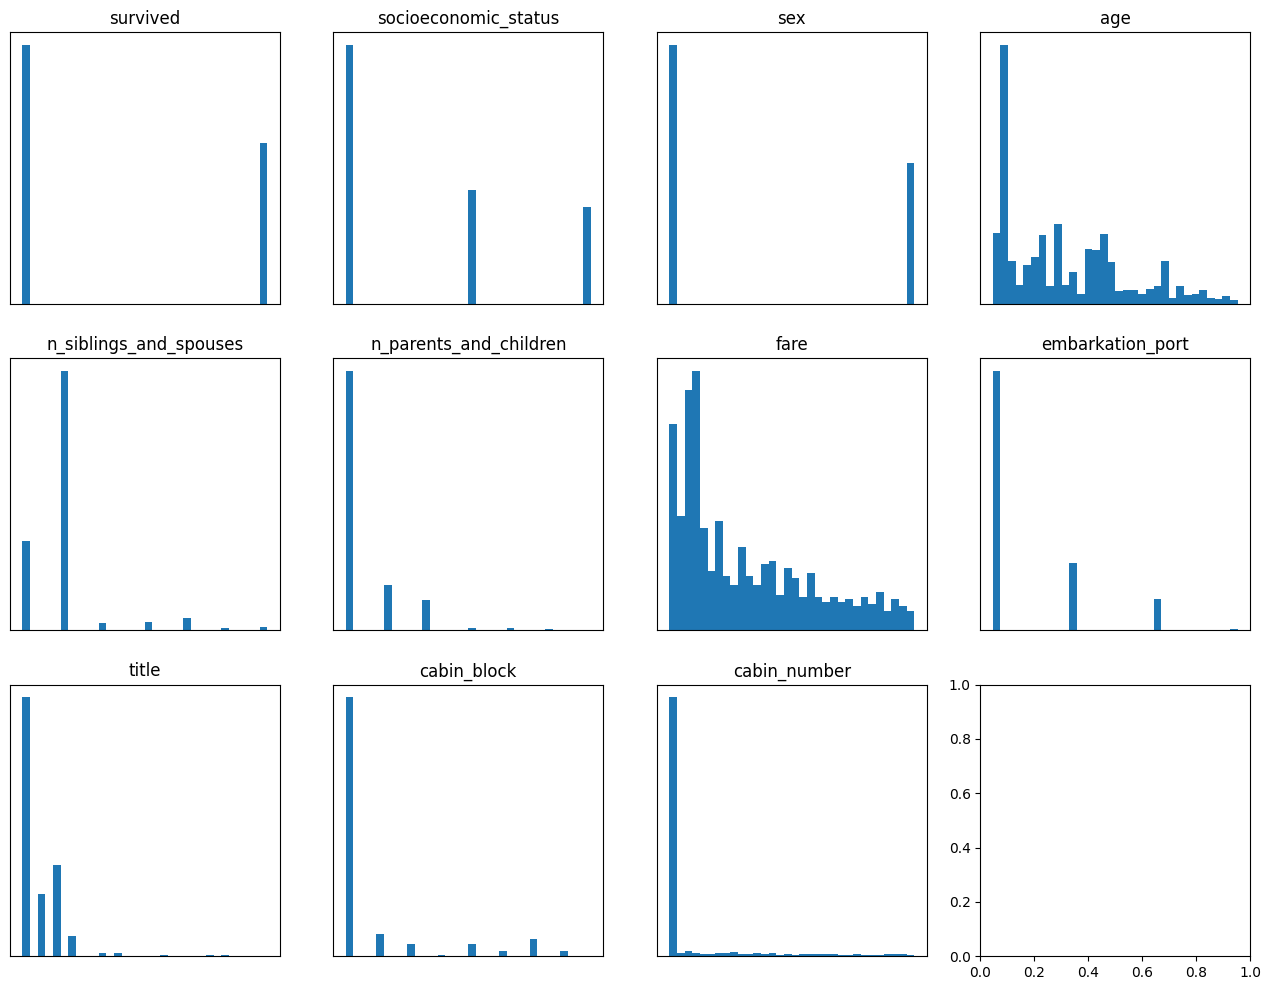

In [239]:
print("--------------------------------------------------")
print("Distributions")
print("--------------------------------------------------")

n_histograms = len(data.columns)
n_histogram_rows = math.ceil(n_histograms / 4)
fig, axes = plt.subplots(ncols=4, nrows=n_histogram_rows)
fig.set_size_inches(16, n_histogram_rows * 4)
axes = axes.flatten()

for index, column in enumerate(data.columns):
    ax = axes[index]
    ax.hist(data[column].astype(str), bins=32)
    ax.set_title(column)
    ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])

In [240]:
def split_data(data: pd.DataFrame):
    X = data.drop(["survived"], axis=1)
    y = data["survived"]
    return X, y


X, y = split_data(data)

In [241]:
print("--------------------------------------------------")
print("Feature Types")
print("--------------------------------------------------")

features = X.columns
cat_features = [
    "socioeconomic_status",
    "sex",
    "embarkation_port",
    "title",
    "cabin_block",
]
num_features = list(filter(lambda item: item not in cat_features, features))

print(f"Categorical Features: {cat_features}")
print(f"Numeric Features: {num_features}")

--------------------------------------------------
Feature Types
--------------------------------------------------
Categorical Features: ['socioeconomic_status', 'sex', 'embarkation_port', 'title', 'cabin_block']
Numeric Features: ['age', 'n_siblings_and_spouses', 'n_parents_and_children', 'fare', 'cabin_number']


In [251]:
def transform_data(data: pd.DataFrame):
    for feature in cat_features:
        data[feature] = data[feature].astype(str)
    for feature in num_features:
        data[feature] = pd.to_numeric(data[feature], errors="coerce").astype(float)
    return data


X = transform_data(X)

--------------------------------------------------
Correlations
--------------------------------------------------


c:\Users\danie\_data\courses\kaggle-competitions\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\_data\courses\kaggle-competitions\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\_data\courses\kaggle-competitions\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\_data\courses\kaggle-competitions\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

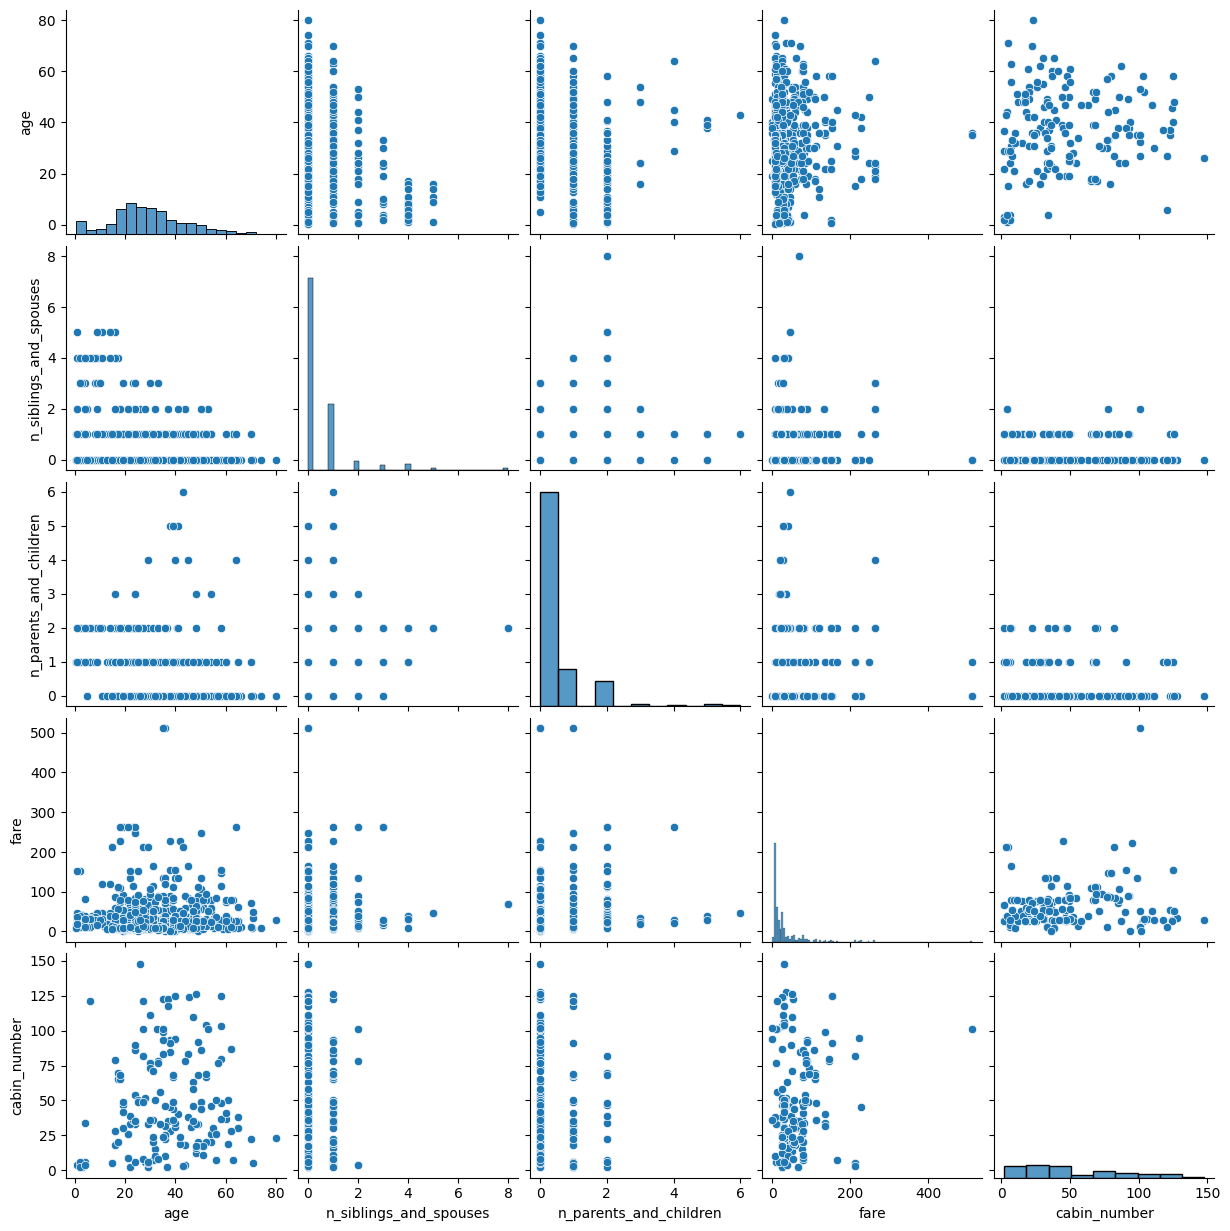

In [252]:
print("--------------------------------------------------")
print("Correlations")
print("--------------------------------------------------")

sns.pairplot(X[num_features])

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [245]:
imputer = ColumnTransformer(
    [
        (
            "imputer_cat",
            SimpleImputer(strategy="most_frequent", add_indicator=True),
            cat_features,
        ),
        (
            "imputer_num",
            KNNImputer(
                missing_values=np.nan,
                n_neighbors=10,
                weights="uniform",
                add_indicator=True,
            ),
            num_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

robust_scaler = ColumnTransformer(
    [
        (
            "robust_scaler",
            RobustScaler(),
            num_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

minmax_scaler = ColumnTransformer(
    [
        (
            "minmax_scaler",
            MinMaxScaler(feature_range=(0, 1)),
            num_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

encoder = ColumnTransformer(
    [
        (
            "encoder_cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

estimator = RandomForestClassifier()

In [246]:
print("------------------------------------------------------------")
print("Base Model")
print("------------------------------------------------------------")

pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("robust_scaler", robust_scaler),
        ("minmax_scaler", minmax_scaler),
        ("encoder", encoder),
        ("estimator", estimator),
    ],
).set_output(transform="pandas")

pipeline.fit(X_train, y_train)

print(f"Test Score: {pipeline.score(X_test, y_test).round(4)}")
print(f"Train Score: {pipeline.score(X_train, y_train).round(4)}")

------------------------------------------------------------
Base Model
------------------------------------------------------------
Test Score: 0.8251
Train Score: 0.9865


In [247]:
print("------------------------------------------------------------")
print("Hypertuned Model")
print("------------------------------------------------------------")

model = GridSearchCV(
    pipeline,
    {
        "estimator__max_features": [0.125, 0.25, 0.5],
        "estimator__min_samples_leaf": [1, 2, 4],
        "estimator__n_estimators": [50, 100, 200],
    },
    cv=5,
    verbose=1,
)

model.fit(X_train, y_train)

model_params = model.best_params_

print(f"Model Parameters: {model_params}")
print(f"Test Score: {model.score(X_test, y_test).round(4)}")
print(f"Train Score: {model.score(X_train, y_train).round(4)}")
print("------------------------------------------------------------")

------------------------------------------------------------
Hypertuned Model
------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Model Parameters: {'estimator__max_features': 0.25, 'estimator__min_samples_leaf': 2, 'estimator__n_estimators': 200}
Test Score: 0.8072
Train Score: 0.9147
------------------------------------------------------------


In [248]:
print("------------------------------------------------------------")
print("Cross-validated Model")
print("------------------------------------------------------------")

best_estimator = RandomForestClassifier(
    max_features=model_params["estimator__max_features"],
    min_samples_leaf=model_params["estimator__min_samples_leaf"],
    n_estimators=model_params["estimator__n_estimators"],
)

best_model = Pipeline(
    [
        ("imputer", imputer),
        ("robust_scaler", robust_scaler),
        ("minmax_scaler", minmax_scaler),
        ("encoder", encoder),
        ("estimator", best_estimator),
    ],
)

best_model.fit(X_train, y_train)

scores = {
    "accuracy": abs(
        cross_val_score(
            best_model,
            X_train,
            y_train,
            cv=5,
            scoring="accuracy",
        ).mean()
    ),
    "precision": abs(
        cross_val_score(
            best_model,
            X_train,
            y_train,
            cv=5,
            scoring="precision",
        ).mean()
    ),
    "recall": abs(
        cross_val_score(
            best_model,
            X_train,
            y_train,
            cv=5,
            scoring="recall",
        ).mean()
    ),
    "f1": abs(
        cross_val_score(
            best_model,
            X_train,
            y_train,
            cv=5,
            scoring="f1",
        ).mean()
    ),
    "roc_auc": abs(
        cross_val_score(
            best_model,
            X_train,
            y_train,
            cv=5,
            scoring="roc_auc",
        ).mean()
    ),
}

print(f"Accuracy: {scores['accuracy'].round(4)}")
print(f"Precision: {scores['precision'].round(4)}")
print(f"Recall: {scores['recall'].round(4)}")
print(f"F1 Score: {scores['f1'].round(4)}")
print(f"ROC AUC: {scores['roc_auc'].round(4)}")

------------------------------------------------------------
Cross-validated Model
------------------------------------------------------------
Accuracy: 0.8309
Precision: 0.8399
Recall: 0.6775
F1 Score: 0.7514
ROC AUC: 0.8314


------------------------------------------------------------
ROC Area under Curve
------------------------------------------------------------


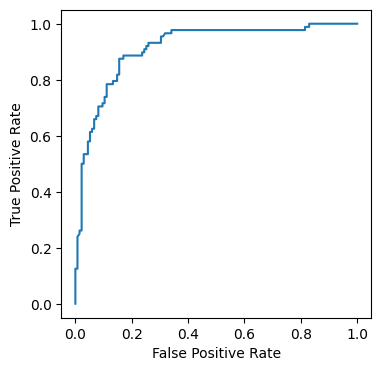

In [249]:
print("------------------------------------------------------------")
print("ROC Area under Curve")
print("------------------------------------------------------------")

y_true = y_test
y_pred_proba = best_model.predict_proba(X_test)[::, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot(fpr, tpr)

In [256]:
def load_data(path: str):
    data = read_data(path)
    data = enrich_data(data)
    data = transform_data(data)
    return data


X_pred = load_data("./data/test.csv")
y_pred = best_model.predict(X_pred)

y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,